In [1]:
import numpy as np
import matplotlib.pyplot as mp
from random import random

Disperse an amount of nano particles $\textit{cantidad_de_np}$ in a sphere.

In [3]:



cantidad_de_np = 10

diametro = 12*10**-9    #Diameter of NP in meters
f = 5*10**-7           #Lisosome radius
B_max = 2.5            #Tesla




def p_punto(m,e,i,j):    #Multiple rows of matrices
    
    s = 0

    for k in range(0,3):
        s = s + m[i,k] * e[j,k]
        
    return s




u_0   = 12.57 * 10**(-7) # H / m

def campo_externo(t):       #External field
    w = 0.5     #Trial value
    H = B_max  * np.sin(w*t)
    return H



## Nanoparticle position



position =  np.matrix(np.empty(shape=(0,3), dtype=float))

#We put the NP inside a sphere in the cartesian coordinates (1,1,1) as a lisosome

n = 0
while n < cantidad_de_np:
    a = 2*random()
    b = 2*random()
    c = 2*random()
    if (a-1)**2 + (b-1)**2 + (c-1)**2 <= 1:
    
        position = np.insert(position, n, [a*f , b*f, c*f], axis = 0)
        n = n + 1


## Easy axis and initial magnetization directions
## Both odf them as unitary vectors


easy_axis = np.matrix(np.empty(shape=(0,3), dtype=float))

for i in range(0,cantidad_de_np):
    a = random()
    b = random()
    c = random()
    d = (a**2 + b**2 + c**2)**0.5
    easy_axis = np.insert(easy_axis, i, [a/d , b/d, c/d], axis = 0)

    
    
magnetizacion = np.matrix(np.empty(shape=(0,3), dtype=float))
    
for i in range(0,cantidad_de_np):
    a = random()
    b = random()
    c = random()
    d = (a**2 + b**2 + c**2)**0.5
    magnetizacion = np.insert(magnetizacion, i, [a/d , b/d, c/d], axis = 0)
    
#magnetizacion,position

Ahora generamos los vectores unitarios que unen a las nanopartículas, junto con las distancias que las separan. Obteneos también el vector del campo magnetico que afecta al dipolo, tanto por las demás NP, como el campo externo.

# Falta comprobar las magnitudes

In [5]:
def campo_total(t): #Total field
    K_eff = 13000                            # J m^-3
    M_s   = 10**6                            # A m^-1
    V     = (4/3)*np.pi*(diametro/2)**3      # m^3
    u_0   = 12.57 * 10**(-7)                 # H / m
    
    
    campo_dipol = np.zeros([cantidad_de_np,3])
    #t = 7*np.pi/(8*628318.5307179586)
    #t = (np.pi/4)/0.5
    
    
    for i in range(0,cantidad_de_np):
        direccion = np.zeros([cantidad_de_np,3]) 
        dipol = [0,0,0]
        #Columna 1 , 2, y 3: vector unitario. Columna 4: distancia
        r = 0
        
        for j in range(0,cantidad_de_np):
            if i != j:
                for k in range(0,3):
                    direccion[j,k] = position[j,k] - position[i,k]
                    r = r + direccion[j,k]**2
                r = r**0.5
                    
                for l in range(0,3):
                    direccion[j,l] = direccion[j,l]/r**0.5
                
                dipol = dipol + (3 * p_punto(magnetizacion,direccion,j,j) * direccion[j,] - magnetizacion[j,]) / r**3
        
        campo_dipol[i,] = (u_0*M_s*V/(4*np.pi))*dipol
        
        campo_dipol[i,2] = campo_dipol[i,2] + campo_externo(t)
        
    return campo_dipol



In [24]:
campo_dipol = campo_total(0)

In [9]:
def angu_mag(campo_dipol):
    angulo_mag      = []       # Easy axis - magnetizacion   -> Theta
    angulo_posicion = []       # Easy axis - magnetic field  -> Phi
    
    for i in range(0,cantidad_de_np):
        w = campo_dipol[i,]
        q = np.matrix(w/(w**2).sum() **0.5)
        plano = np.cross(q,easy_axis[i,])
        
        ang_2 = np.arccos(p_punto(q,easy_axis[i,],0,0))     #Phi
        angulo_posicion.append(ang_2)
        
        ang_1 = np.arccos(p_punto(easy_axis,magnetizacion,0,i))
        angulo_mag.append(ang_1)
        
    return
    

In [12]:
angulo_mag      = []       # Easy axis - magnetizacion   -> Theta
angulo_posicion = []       # Easy axis - magnetic field  -> Phi

for i in range(0,cantidad_de_np):
    w = campo_dipol[i,]
    q = np.matrix(w/(w**2).sum() **0.5)
    plano = np.cross(q,easy_axis[i,])
    
    
    ang_2 = np.arccos(p_punto(q,easy_axis[i,],0,0))     #Phi
    angulo_posicion.append(ang_2)

    ang_1 = np.arccos(p_punto(easy_axis,magnetizacion,0,i))
    angulo_mag.append(ang_1)
    
#angulo_posicion,angulo_mag
angulo_mag

[0.8667239224668556,
 0.3648588371959342,
 0.5343571057884074,
 1.2426404522524044,
 1.0927415129192894,
 0.6974747949808991,
 0.15370696484743054,
 0.5350606533587862,
 0.6347841690874511,
 0.7613182943326658]


Queremos obtener el campo total, para lo cual necesitamos obtener el campo externo en cada instante del tiempo.

Lo que haremos será dividir el tiempo, que se requiere para completar un ciclo de cambio en el campo externo, en 2000 pasos.

# Obtenemos los ángulos


In [29]:
# i es el índice de la i-ésima NP

def energia(theta,i):   #Energy function
    K_eff = 10**6           # J m^-3
    V     = (4/3)*np.pi*(diametro/2)**3      # m^3
    u_0   = 12.57 * 10**(-7) # H / m
    M_s   = 10**6            # A m^-1

    
    campo = (campo_dipol[i,]**2).sum() **0.5
    
    #return np.sin(theta)**2 - -2*np.cos(theta-np.pi/6)   E / K_b T
    #return campo
    return (K_eff*V)*np.sin(theta)**2 - (M_s*V*campo)*np.cos(theta-angulo_mag[i])
    

def derivada_ener(x,i):
    h = 0.0000001
    d = (energia(x+h,i) - energia(x,i) )/ h
    return d

In [13]:
def probabilidad(i):  #i es el número de nanopartícula
    t_step = 2*np.pi/(0.5 * 2000)
    raices = []
    energies = []
    
    tolerancia = 0.0001
    cota_de_error = np.pi/100
    
    h = 0.00001
    paso = 5/200
    
    K_B   = 1.38064852 * 10**(-23) # m^2 kg s^-2 K^-1
    T     = 300
    
    v_10, v_20 = 10**10,10**10
    
    #t_step = 0.00005
    
    for j in range(0,200):    #comienza en 4 para evitar encontrar la raiz trivial (el máximo global)
        
        a = 4 - paso*j
        c = 4 - (1 + j)*paso
        d_1 = derivada_ener(a,i) 
        d_2 = derivada_ener(c,i)
        if (d_1 < 0 and d_2 > 0):
        #if (d_1 > 0 and d_2 < 0):
        
            x_0 = c
            
            
            
            for l in range (0,10):
                dderiv_ener = (derivada_ener(x_0 + h,i)-derivada_ener(x_0,i) )/h
                x_i = x_0 - derivada_ener(x_0,i)/dderiv_ener
                
                x_0 = x_i
                
            raices.append(x_0)
            energies.append(energia(x_0,i))
            #print(derivada_ener(c,i))
            
        elif (d_1 > 0 and d_2 < 0):
        #elif (d_1 < 0 and d_2 > 0):
       
            x_0 = c
            
            
            
            for l in range (0,10):
                dderiv_ener = (derivada_ener(x_0 + h,i)-derivada_ener(x_0,i) )/h
                x_i = x_0 - derivada_ener(x_0,i)/dderiv_ener
                
                x_0 = x_i
                
            raices.append(x_0)
            energies.append(energia(x_0,i))
            #print(derivada_ener(c,i))
        
    if np.shape(raices) == (3,):
        #CALCULAMOS V_1 Y V_2
        v_2 = v_10 * np.exp(-(energies[1] - energies[0])/(K_B*T))
        
        v_1 = v_20 * np.exp(-(energies[1] - energies[2])/(K_B*T))
        
        P_21 = v_2/(v_1 + v_2) *(1 - np.exp(-(v_1 + v_2)*t_step))
        #P_21 =  (np.exp(-(v_1 + v_2)*t_step))
        
        return P_21
    #return energies[1]-energies[0],energies[1]-energies[2]

In [19]:
probabilidad(5)

In [9]:
campo_dipol = campo_total(6)

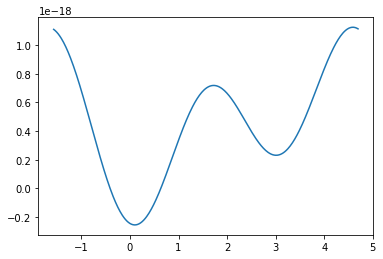

In [21]:

x = np.arange(-1/2 *np.pi,3/2 *np.pi,1*np.pi/200)



mp.plot(x,energia(x,5))

In [32]:
maxi = raices(8)
#energies = ener_raices(raices)



TypeError: 'list' object is not callable

In [27]:
def raices(i):  #i es el número de nanopartícula
    raices = []
    
    
    tolerancia = 0.0001
    cota_de_error = np.pi/100
    
    h = 0.00001
    paso = 5/200
    
    K_B   = 1.38064852 * 10**(-23) # m^2 kg s^-2 K^-1
    T     = 300
    
    v_10, v_20 = 10**10,10**10
    
    t_step = 0.00005
    
    for j in range(0,200):    #comienza en 4 para evitar encontrar la raiz trivial (el máximo global)
        
        a = 4 - paso*j
        c = 4 - (1 + j)*paso
        d_1 = derivada_ener(a,i) 
        d_2 = derivada_ener(c,i)
        if (d_1 < 0 and d_2 > 0):
        #if (d_1 > 0 and d_2 < 0):
        
            x_0 = c
            
            
            
            for l in range (0,10):
                dderiv_ener = (derivada_ener(x_0 + h,i)-derivada_ener(x_0,i) )/h
                x_i = x_0 - derivada_ener(x_0,i)/dderiv_ener
                
                x_0 = x_i
                
            raices.append(x_0)
            #energies.append(energia(x_0,i))
            #print(derivada_ener(c,i))
            
        elif (d_1 > 0 and d_2 < 0):
        #elif (d_1 < 0 and d_2 > 0):
       
            x_0 = c
                        
            for l in range (0,10):
                dderiv_ener = (derivada_ener(x_0 + h,i)-derivada_ener(x_0,i) )/h
                x_i = x_0 - derivada_ener(x_0,i)/dderiv_ener
                
                x_0 = x_i
            raices.append(x_0)
                
    return raices                
            
    
def ener_raices(j):
    energies = []
    
    for i in range(0,2):
        energies.append(energia(raices[i],j))
        
    return energies
            
        
def probability(i):
    
    
    if np.shape(raices) == (3,):
        #CALCULAMOS V_1 Y V_2
        v_2 = v_10 * np.exp(-(energies[1] - energies[0])/(K_B*T))
        
        v_1 = v_20 * np.exp(-(energies[1] - energies[2])/(K_B*T))
        
        P_21 = v_2/(v_1 + v_2) *(1 - np.exp(-(v_1 + v_2)*t_step))
        #P_21 =  (np.exp(-(v_1 + v_2)*t_step))
        
        return P_21
    #return energies[1]-energies[0],energies[1]-energies[2]

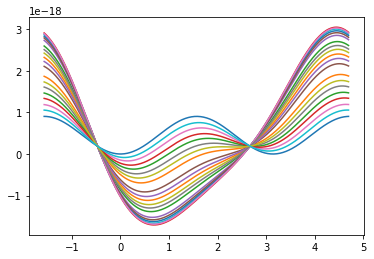

In [36]:
x = np.arange(-1/2 *np.pi,3/2 *np.pi,1*np.pi/200)

for i in range(0,20):
    campo_dipol = campo_total(i)
    
    mp.plot(x,energia(x,5))
    
mp.show()